In [1]:
# 魔术指令，自动加载模块
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beihang/xihu/HZTourism/FlowPred-dev')
import os
os.chdir("/home/beihang/xihu/HZTourism/FlowPred-dev")
import pandas as pd
import numpy as np
from utils.utils_data import interactive_plot_comparison,fill_missing_value_singlespot_day,get_daydata_distribution
from Loss.PearsonMSELoss import pearson_mse_loss_xgb_test
import datetime


In [2]:
""" 预测值 """
df = pd.read_csv("data/0523/14100_pred20250501-0522.csv")
# 筛选spot_id=14100的数据
df["start_time"] = pd.to_datetime(df["start_time"])
df['prediction_step_time'] = pd.to_datetime(df['prediction_step_time'])
# 按照start_time升序排序
df = df.sort_values("start_time")
# 最远端
# last_prediction = df.loc[df.groupby('start_time')['prediction_step_time'].idxmax()]
# 最近端
last_prediction = df.loc[df.groupby('start_time')['prediction_step_time'].idxmin()]
df_last_prediction = last_prediction[['start_time', 'prediction_step_time', 'prediction_step_value']]
# 去除start_time列
df_last_prediction = df_last_prediction.drop(columns=["start_time"])
# 重命名列名
df_last_prediction = df_last_prediction.rename(columns={"prediction_step_time": "kpi_time", "prediction_step_value": "kpi_value"})
df_last_prediction["kpi_time"] = pd.to_datetime(df_last_prediction["kpi_time"])
# 按照kpi_time升序排序
df_last_prediction = df_last_prediction.sort_values("kpi_time")
# 数据按时间去重
df_last_prediction = df_last_prediction.drop_duplicates("kpi_time")
# 筛选kpi_time日期小于2025年5月19日的数据
df_last_prediction = df_last_prediction[df_last_prediction["kpi_time"].dt.date < datetime.date(2025, 5, 19)]

In [3]:
df_last_prediction["spot_id"] = 14100
# 填充缺值
df_pred_filled = fill_missing_value_singlespot_day(df_last_prediction)

In [4]:
""" 真实值 """
df_real = pd.read_csv("data/0523/14100_real.csv")
df_real["kpi_time"] = pd.to_datetime(df_real["kpi_time"])
df_real = df_real.sort_values(by="kpi_time")
df_real = df_real.drop(columns=["id", "kpi_id"])
df_real = df_real.drop_duplicates(subset=["kpi_time"])
# 筛选kpi_time日期小于2025年5月19日的数据
df_real = df_real[df_real["kpi_time"] < pd.to_datetime("2025-05-19")]

In [5]:
# 填充缺值
df_real_filled = fill_missing_value_singlespot_day(df_real)

In [6]:
# 拼接成一个DataFrame
df_res = pd.DataFrame(
    {   
        "time": df_real_filled["kpi_time"].values,
        "real": df_real_filled["kpi_value"].values,
        "pred": df_pred_filled["kpi_value"].values,
    }
)

In [7]:
# 按time列的日期分组
df_res_groups = df_res.groupby(df_res["time"].dt.date)
real_array = np.array([group[1]["real"].values for group in list(df_res_groups)])
pred_array = np.array([group[1]["pred"].values for group in list(df_res_groups)])

In [8]:
np.mean(np.abs(real_array-pred_array)/real_array),np.mean(np.abs(real_array[0]-pred_array[0])/real_array[0])

(0.05207877536332949, 0.0511320534685028)

In [9]:
loss_list = [[]]
for real, pred in zip(real_array, pred_array):
    loss_list[0].append(pearson_mse_loss_xgb_test(real, pred))

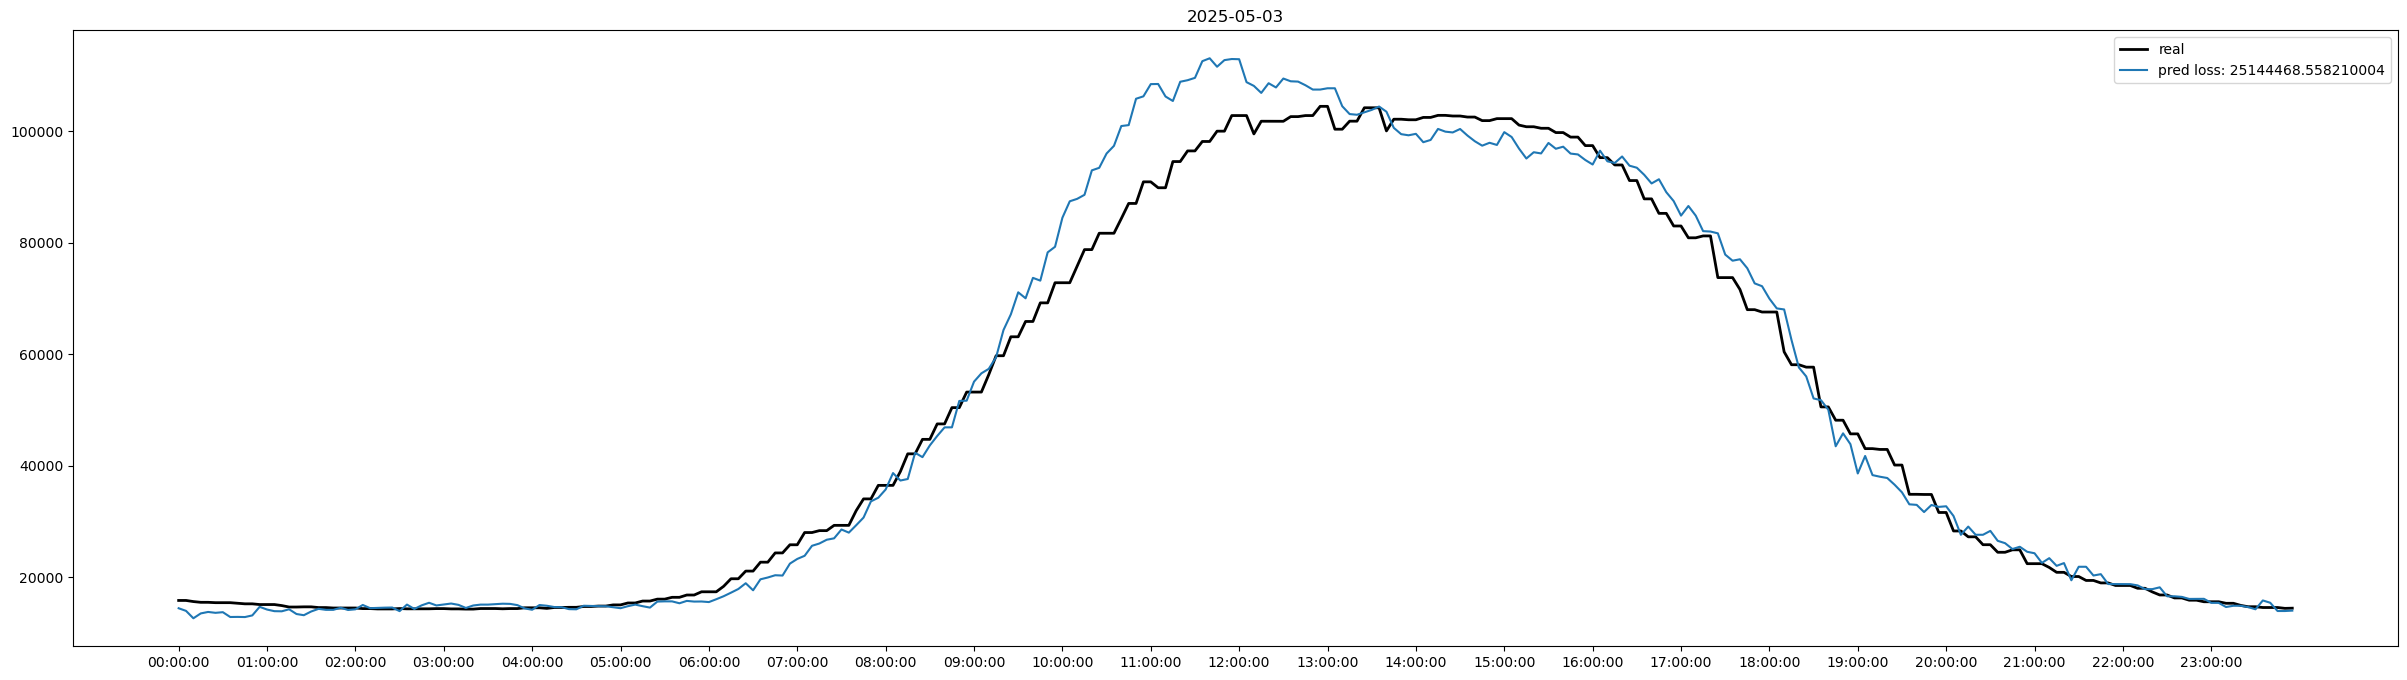

In [ ]:
groups_labels=["pred"]

grouped_datasets = [list(df_res_groups)]
interactive_plot_comparison(
    groups_labels,
    loss_list,
    *grouped_datasets
)